In [ ]:
!pip install torchinfo

In [ ]:
import os, os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class EMGDataset(Dataset):
    def __init__(self, folder_path, window_size, moving_avg_delay):
        self.folder_path = folder_path
        self.window_size = window_size
        self.moving_avg_delay = moving_avg_delay
        self.X, self.Y = self.load_and_label()

    def load_and_label(self):
        X = []
        Y = []
        for root, _, files in os.walk(self.folder_path):
            for file in files:
                # Check if the file is a text file (e.g., .txt, .csv)
                if not file.endswith(('.txt', '.csv')):  # Add other relevant extensions if needed
                    continue  # Skip non-text files

                # Load EMG data using NumPy, specifying the encoding
                with open(os.path.join(root, file), 'r', encoding='latin-1') as f:  # or 'cp1252'
                    emg_data = np.loadtxt(f, delimiter='\t')  # Assuming tab-delimited

                for k in range(0, emg_data.shape[0] - self.window_size + 1, self.window_size):
                    d = emg_data[k : k + self.window_size, :]
                    d = np.abs(d)
                    for n in range(d.shape[1] - 1):
                        d[:, n] = np.convolve(d[:, n], np.ones(self.moving_avg_delay) / self.moving_avg_delay, mode='same')
                    X.append(d)
                    label = int(file.split(".")[0])
                    Y.append(label)

        X = np.array(X)
        X = X / np.max(X)  # Normalize
        Y = np.array(Y)
        Y = self.to_one_hot(Y)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

    def to_one_hot(self, Y):
        num_classes = np.max(Y) + 1
        one_hot = np.zeros((len(Y), num_classes))
        one_hot[np.arange(len(Y)), Y] = 1
        return one_hot

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
# Example usage
folder_path = "/content/drive/MyDrive/EMG hand gestures dataset"
window_size = 200
moving_avg_delay = 20

dataset = EMGDataset(folder_path, window_size, moving_avg_delay)

# Manually split into train and test sets (replace with your desired method)
data_len = len(dataset)
indices = list(range(data_len))
np.random.shuffle(indices)  # Shuffle indices

train_size = int(0.8 * data_len)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
class EMGModel(nn.Module):
    def __init__(self):
        super(EMGModel, self).__init__()
        self.fc1 = nn.Linear(200 * 4, 32)  # Input: 200 time steps * 4 channels
        self.tanh1 = nn.Tanh()
        self.lstm = nn.LSTM(32, 16, batch_first=True)  # Input: 32 features from fc1
        self.fc2 = nn.Linear(16, 32)  # Input: 16 features from LSTM
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(32, 5)  # Output: 5 classes
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for output

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        #x = x.view(batch_size, -1)  # Flatten input to (batch_size, 200*4)
        x = self.tanh1(self.fc1(x))

        # Reshape for LSTM: (batch_size, sequence_length, input_size)
        # Assuming sequence_length = 1 for now (you might need to adjust this)
        x = x.view(batch_size, 1, -1)

        # Pass through LSTM and get the output
        x, _ = self.lstm(x)

        # Take the output from the last time step (since sequence_length = 1)
        x = x[:, -1, :]

        x = self.tanh2(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def validate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
            actual_class_indices = torch.argmax(target, dim=1)
            correct += pred.eq(actual_class_indices.view_as(pred)).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    return avg_loss, accuracy

In [ ]:
# Instantiate the model, optimizer, and loss function
model = EMGModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
# Training loop
for epoch in range(1000):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target) # Calculate loss, convert target to long
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights

    # Validation

    val_loss, val_accuracy = validate(model, test_loader, criterion)
    print(f"Epoch {epoch}: Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

    # Append losses
    train_losses.append(loss.item()) # Append training loss for current batch
    val_losses.append(val_loss)

# Add EMGModel to safe globals
torch.serialization.add_safe_globals([EMGModel])

Epoch 0: Val Loss = 1.5806, Val Accuracy = 36.02%
Epoch 1: Val Loss = 1.5375, Val Accuracy = 22.95%
Epoch 2: Val Loss = 1.4595, Val Accuracy = 48.11%
Epoch 3: Val Loss = 1.3332, Val Accuracy = 59.34%
Epoch 4: Val Loss = 1.1703, Val Accuracy = 65.20%
Epoch 5: Val Loss = 1.0196, Val Accuracy = 68.99%
Epoch 6: Val Loss = 0.8997, Val Accuracy = 72.28%
Epoch 7: Val Loss = 0.8037, Val Accuracy = 77.53%
Epoch 8: Val Loss = 0.7119, Val Accuracy = 78.27%
Epoch 9: Val Loss = 0.6332, Val Accuracy = 80.22%
Epoch 10: Val Loss = 0.5647, Val Accuracy = 80.71%
Epoch 11: Val Loss = 0.5134, Val Accuracy = 82.17%
Epoch 12: Val Loss = 0.4738, Val Accuracy = 83.39%
Epoch 13: Val Loss = 0.4459, Val Accuracy = 84.86%
Epoch 14: Val Loss = 0.4279, Val Accuracy = 86.08%
Epoch 15: Val Loss = 0.4143, Val Accuracy = 85.96%
Epoch 16: Val Loss = 0.3949, Val Accuracy = 86.20%
Epoch 17: Val Loss = 0.3856, Val Accuracy = 87.30%
Epoch 18: Val Loss = 0.3866, Val Accuracy = 86.32%
Epoch 19: Val Loss = 0.3686, Val Accuracy

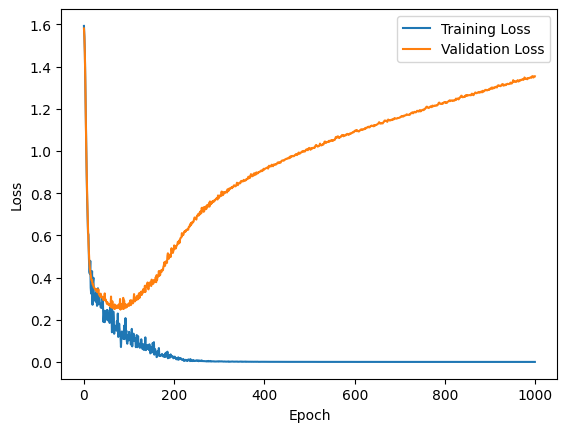

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 0: Val Loss = 1.5911, Val Accuracy = 31.38%
Epoch 1: Val Loss = 1.5479, Val Accuracy = 24.91%
Epoch 2: Val Loss = 1.4691, Val Accuracy = 49.21%
Epoch 3: Val Loss = 1.3307, Val Accuracy = 60.07%
Epoch 4: Val Loss = 1.1340, Val Accuracy = 66.91%
Epoch 5: Val Loss = 0.9491, Val Accuracy = 72.65%
Epoch 6: Val Loss = 0.8006, Val Accuracy = 82.30%
Epoch 7: Val Loss = 0.6946, Val Accuracy = 82.30%
Epoch 8: Val Loss = 0.5985, Val Accuracy = 82.05%
Epoch 9: Val Loss = 0.5337, Val Accuracy = 84.25%
Epoch 10: Val Loss = 0.4883, Val Accuracy = 84.13%
Epoch 11: Val Loss = 0.4565, Val Accuracy = 85.59%
Epoch 12: Val Loss = 0.4313, Val Accuracy = 85.23%
Epoch 13: Val Loss = 0.4149, Val Accuracy = 85.71%
Epoch 14: Val Loss = 0.3981, Val Accuracy = 86.94%
Epoch 15: Val Loss = 0.3869, Val Accuracy = 86.20%
Epoch 16: Val Loss = 0.3763, Val Accuracy = 88.03%
Epoch 17: Val Loss = 0.3713, Val Accuracy = 88.28%
Epoch 18: Val Loss = 0.3694, Val Accuracy = 88.40%
Epoch 19: Val Loss = 0.3595, Val Accuracy

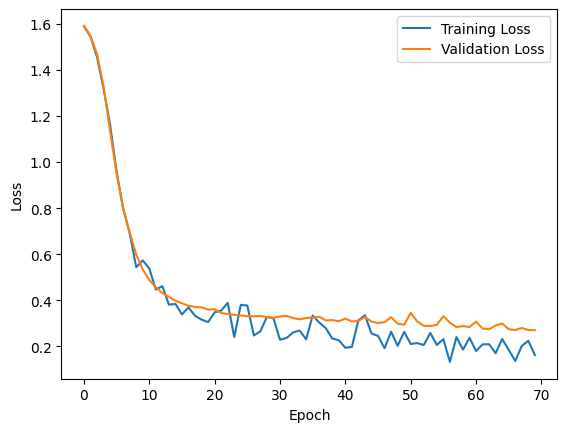

In [ ]:
# Instantiate the model, optimizer, and loss function
model = EMGModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
# Training loop
for epoch in range(70):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target) # Calculate loss, convert target to long
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights

    # Validation

    val_loss, val_accuracy = validate(model, test_loader, criterion)
    print(f"Epoch {epoch}: Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

    # Append losses
    train_losses.append(loss.item()) # Append training loss for current batch
    val_losses.append(val_loss)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.serialization.add_safe_globals([EMGModel])

In [ ]:
torch.save(model, '/content/drive/MyDrive/EMG hand gestures dataset/model.pth')

In [ ]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == torch.argmax(target, dim=1)).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def test_model_with_confusion_matrix(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_predicted = []
    all_targets = []
    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_targets.extend(torch.argmax(target, dim=1).cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predicted)

    # Normalize confusion matrix to percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Display confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Percentages)")
    plt.show()

    return cm # Return the original confusion matrix (with raw counts)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def test_model_with_confusion_matrix_original(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_predicted = []
    all_targets = []
    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_targets.extend(torch.argmax(target, dim=1).cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predicted)

    # Display confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # fmt="d" for integers
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Raw Counts)")
    plt.show()

    return cm  # Return the original confusion matrix (with raw counts)

In [ ]:
torch.serialization.add_safe_globals([EMGModel, nn.Linear, nn.Tanh, nn.LSTM])

In [ ]:
# Load the saved model
#model = torch.load('/content/drive/MyDrive/EMG hand gestures dataset/model.pth')

In [ ]:
test_model(model, test_loader)

Test Accuracy: 89.74%


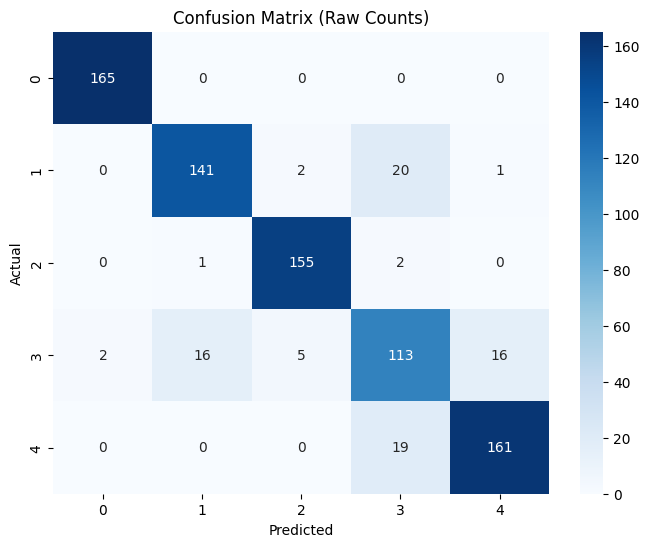

In [ ]:
#Call the function with your model and test_loader
cm = test_model_with_confusion_matrix_original(model, test_loader)

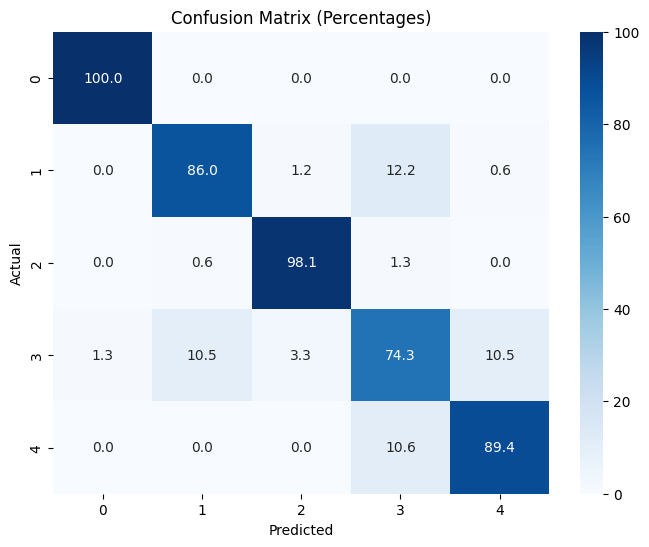

In [ ]:
#Call the function with your model and test_loader
cm = test_model_with_confusion_matrix(model, test_loader)

In [ ]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        print(f"Layer: {name} | Parameters: {param}")
    print(f"----------------------------")
    print(f"Total trainable parameters: {total_params}")


def model_summary(model):
    """Prints a summary of the model's architecture and parameters."""
    print(model)  # Print model architecture
    count_parameters(model)  # Print per-layer and total parameter counts

model_summary(model)

EMGModel(
  (fc1): Linear(in_features=800, out_features=32, bias=True)
  (tanh1): Tanh()
  (lstm): LSTM(32, 16, batch_first=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (tanh2): Tanh()
  (fc3): Linear(in_features=32, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)
Layer: fc1.weight | Parameters: 25600
Layer: fc1.bias | Parameters: 32
Layer: lstm.weight_ih_l0 | Parameters: 2048
Layer: lstm.weight_hh_l0 | Parameters: 1024
Layer: lstm.bias_ih_l0 | Parameters: 64
Layer: lstm.bias_hh_l0 | Parameters: 64
Layer: fc2.weight | Parameters: 512
Layer: fc2.bias | Parameters: 32
Layer: fc3.weight | Parameters: 160
Layer: fc3.bias | Parameters: 5
----------------------------
Total trainable parameters: 29541


In [ ]:
import sys
import numpy as np

def get_model_size(model):
    """Calculates the size of a PyTorch model in MB.

    Args:
        model: The PyTorch model.

    Returns:
        The size of the model in MB.
    """
    total_size = 0
    for param in model.parameters():  # Iterate over model parameters
        total_size += param.nelement() * param.element_size()

    total_size_mb = total_size / (1024 * 1024)  # Convert to MB
    return total_size_mb

# Get the model size
model_size_mb = get_model_size(model)
print(f"Model size: {model_size_mb:.2f} MB")

Model size: 0.11 MB
